<a href="https://colab.research.google.com/github/Sheepybloke2-0/CSE841-Project/blob/main/gan_art1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN for Creating Color Images from a WikiArt Dataset


In [1]:
# Check that imports for the rest of the file work.
import tensorflow as tf

!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs
!pip install -q kaggle

import matplotlib.pyplot as plt
import numpy as np
# Allow matplotlib images to render immediately.
%matplotlib inline

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow_datasets as tfds

from IPython import display

     |████████████████████████████████| 1.0MB 5.7MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
from google.colab import files
import pathlib
kaggleJson = pathlib.Path("/content/.kaggle/kaggle.json")
if not kaggleJson.is_file():
  # files.upload()
  !mkdir -p /content/.kaggle/
  %cd /content/gdrive/My\ Drive/
  !cp ./kaggle.json /content/.kaggle/
  !chmod 600 /content/.kaggle/kaggle.json
%env KAGGLE_CONFIG_DIR=/content/.kaggle
!echo $KAGGLE_CONFIG_DIR
!kaggle config view
!kaggle datasets list

env: KAGGLE_CONFIG_DIR=/content/.kaggle
/content/.kaggle
Configuration values from /content/.kaggle
- username: reubenlewis
- path: None
- proxy: None
- competition: None
ref                                                          title                                           size  lastUpdated          downloadCount  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
alexgude/california-traffic-collision-data-from-switrs       California Traffic Collision Data from SWITRS    1GB  2020-11-22 16:51:55            920  
babyoda/women-entrepreneurship-and-labor-force               Women Entrepreneurship and Labor Force           1KB  2020-11-21 08:38:51           2455  
szymonjanowski/internet-articles-data-with-users-engagement  Internet news data with readers engagement       3MB  2020-11-21 17:09:57           1171  
sakshigoyal7/credit-card-customers                           Credit C

In [8]:
# %cd /content/gdrive/My\ Drive 
# !kaggle datasets download -d ipythonx/wikiart-gangogh-creating-art-gan
# !rm -r /content/trainSet/
# !rm -r /content/testSet/
# artLib = pathlib.Path('/content/gdrive/My Drive/artgenreset.zip')
artLib = pathlib.Path('/content/gdrive/My Drive/wikiart-gangogh-creating-art-gan.zip')
if not artLib.is_file():
  %cd /content/gdrive/My\ Drive/
  # !kaggle datasets download -d parkerzmartin/artgenreset
  !kaggle datasets download -d ipythonx/wikiart-gangogh-creating-art-gan
  !ls
  # !unzip artgenreset.zip
  !unzip wikiart-gangogh-creating-art-gan.zip -d /content/
else:
  %cd /content/gdrive/My\ Drive/
  # !unzip -u artgenreset.zip -d /content/ 
  !unzip wikiart-gangogh-creating-art-gan.zip -d /content/
  # !rm wikiart-gangogh-creating-art-agan.zip
# dataDir = tf.keras.utils.get_file(origin=datasetURL, fname='wikiArt', extract=True)

Streaming output truncated to the last 5000 lines.
  inflating: /content/still-life/55bcc9e1b914c4490f320b65efc91736c.jpg  
  inflating: /content/still-life/560140270766ce421fb8e6fdfc5d649ec.jpg  
  inflating: /content/still-life/562843932429acb8192900b1816d65bcc.jpg  
  inflating: /content/still-life/563e3706fd8258dfc750d91a11ef2cd8c.jpg  
  inflating: /content/still-life/56412c99702c33952475a32c962dcff0c.jpg  
  inflating: /content/still-life/5674ea7a997a3fae603e2cc3844aa808c.jpg  
  inflating: /content/still-life/5675cdb5e9488e298e1686bad3f60b46c.jpg  
  inflating: /content/still-life/567fcef3ee874b44e8bb5066839f581bc.jpg  
  inflating: /content/still-life/56826a3d23df262fca95687eaf755bbac.jpg  
  inflating: /content/still-life/568cc91147ad915386e1a9fcbf58d386c.jpg  
  inflating: /content/still-life/5698d9c5d5b1e40b97e12c46e7675fa7c.jpg  
  inflating: /content/still-life/56a89b5387633ec9df59460f02b53328c.jpg  
  inflating: /content/still-life/56b4b991edfdd88dc9016be3dc2162f2c.jpg  


In [ ]:
# from cv2 import imread
# from os import listdir

# #for filename in listdir('C:/tensorflow/models/research/object_detection/images/train'):
# for dir in listdir('/content/trainSet'):
#   path = os.path.join('/content/trainSet/', dir)
#   for filename in listdir(path):
#     if filename.endswith(".jpg"):
#       print(path+filename)
#       imread(path+filename)
%cd /content/
!rm -r sample_data
# !rm -r wikiart
!rm -r abstract
!rm -r animal-painting
!rm -r cityscape
!rm -r figurative
!rm -r flower-painting
!rm -r genre-painting
# !rm -r abstract
# !rm -r abstract

/content
rm: cannot remove 'sample_data': No such file or directory


In [9]:
rootDir = pathlib.Path('/content/')
%cd /content/
# imageCount = len(list(rootDir.glob('*/*.jpg')))
# imageCount = len(list(rootDir.glob('abstract/*')))
!mkdir -p wikiart
# !mv ./wikiart/land/ .
!mv ./landscape/ wikiart/
# !mv ./figurative wikiart/
# !mv ./marina/ wikiart/
# !mv ./cityscape/ wikiart/
# !mv ./ wikiart/
# !mv ./abstract wikiart/
# !mv ./wikiart/portrait ./
imageCount = len(list(rootDir.glob('wikiart/*/*.jpg')))
png = len(list(rootDir.glob('trainSet/*/*.png')))
py = len(list(rootDir.glob('trainSet/*/*.py')))

print(imageCount)
print(png)
print(py)

/content
15000
0
0


In [81]:
# Parameters
# Total number of images
BUFFER_SIZE = imageCount
# Size of images to take and train with
BATCH_SIZE = 128
# BATCH_SIZE = 32
# Number of cycles
EPOCHS = 250
im_size = (64, 64)
# im_size = (128, 128)
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [34]:
# Loads the data in from the real training set
# trainPath = os.path.join(rootDir, 'trainSet')
trainPath = os.path.join(rootDir, 'wikiart')
# testPath = os.path.join(rootDir, 'testSet')
trainDataSet = tf.keras.preprocessing.image_dataset_from_directory(
    # rootDir,
    trainPath,
    # validation_split=0.2, # Start with 80/20 split for validation
    # subset="training",
    seed=123,
    image_size=im_size,
    batch_size=BATCH_SIZE
)

# testDataSet = tf.keras.preprocessing.image_dataset_from_directory(
#     trainPath,
#     # rootDir,
#     validation_split=0.0, # Start with 80/20 split for validation
#     subset="validation",
#     seed=123,
#     image_size=im_size,
#     batch_size=BATCH_SIZE
# )

classNames = trainDataSet.class_names
print(classNames)

# Double check that our data is in the correct shape
print(trainDataSet.element_spec)
trainDataSet = trainDataSet.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
trainDataSet.shuffle(buffer_size=BUFFER_SIZE)
trainDataSet = trainDataSet.apply(tf.data.experimental.ignore_errors())

Found 15000 files belonging to 1 classes.
['landscape']
(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


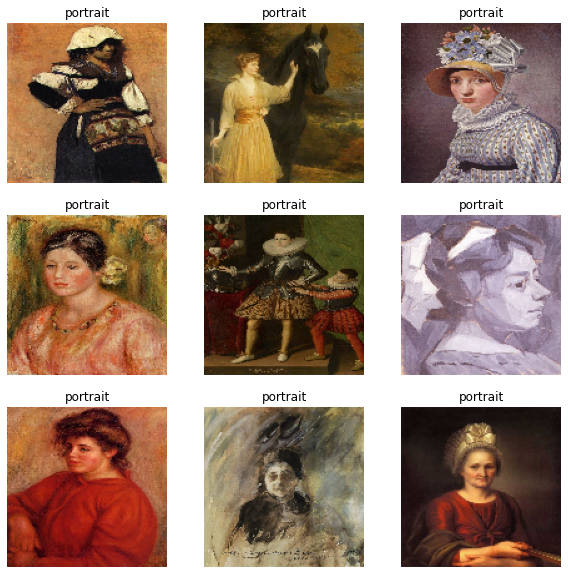

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in trainDataSet.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classNames[labels[i]])
    plt.axis("off")

In [35]:
# Create a layer to scale the images to around [-1, 1]
normLayer = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)

normTrainDS = trainDataSet.map(lambda x, y: (normLayer(x), y))
normTrainDS.shuffle(BUFFER_SIZE)

print(normTrainDS.element_spec)
img, labels = next(iter(normTrainDS))
first = img[0]
print(np.min(first), np.max(first))

(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
-0.9210631 0.9142617


In [78]:
def make_generator_model():
    # Using the structure defined here: https://towardsdatascience.com/developing-a-dcgan-model-in-tensorflow-2-0-396bc1a101b2
    # Will upscale for 128x128: https://cpang4.github.io/gan/content/architecture.png
    model = tf.keras.Sequential()

    # Create our densely connected layer from the random input data
    # model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(layers.Dense(4*4*1028, activation='relu', input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Reshape((4, 4, 1028)))
    assert model.output_shape == (None, 4, 4, 1028) # Note: None is the batch size

    # Upsample and use our model to create an image based on inputs
    model.add(layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    # model.add(layers.Conv2DTranspose(256, (3, 3), padding='same', use_bias=False))
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(512, kernel_size=3, padding="same"))
    print(model.output_shape)
    # assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))

    # model.add(layers.Conv2DTranspose(256, (3, 3), padding='same', use_bias=False))
    model.add(layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    # model.add(layers.UpSampling2D())
    # model.add(layers.Conv2D(256, kernel_size=3, padding="same"))
    print(model.output_shape)
    # assert model.output_shape == (None, 4, 4, 256)
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))

    # for i in range(3):
    #   model.add(layers.UpSampling2D())
    #   model.add(layers.Conv2D(128, kernel_size=3, padding="same"))
    #   print(model.output_shape)
    #   # assert model.output_shape == (None, 4, 4, 256)
    #   model.add(layers.BatchNormalization(momentum=0.8))
    #   model.add(layers.LeakyReLU(0.2))

    # model.add(layers.UpSampling2D())
    # model.add(layers.Conv2D(128, kernel_size=3, padding="same"))
    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    print(model.output_shape)
    # assert model.output_shape == (None, 4, 4, 256)
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))

    # model.add(layers.UpSampling2D())
    # model.add(layers.Conv2D(64, kernel_size=3, padding="same"))
    print(model.output_shape)
    # assert model.output_shape == (None, 4, 4, 256)
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(0.2))

    # model.add(layers.UpSampling2D())
    # model.add(layers.Conv2D(32, kernel_size=3, padding="same"))
    # print(model.output_shape)
    # # assert model.output_shape == (None, 4, 4, 256)
    # model.add(layers.BatchNormalization(momentum=0.8))
    # model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # assert model.output_shape == (None, 64, 64, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # model.add(layers.Conv2DTranspose(3, (5, 5), padding='same', use_bias=False, activation='tanh'))
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    # model.add(layers.Conv2D(3, kernel_size=3, padding="same"))
    # model.add(layers.Activation("tanh"))

    input = layers.Input(shape=(noise_dim,))
    generated_image = model(input)
    print(model.output_shape)
    # assert model.output_shape == (None, 128, 128, 3)

    return tf.keras.models.Model(input, generated_image)


In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image = (generated_image + 1) /2
plt.imshow(generated_image[0] )
print(generated_image[0, 1, 1, :])
generator.summary()

NameError: ignored

In [77]:
def make_discriminator_model():
    # TODO: maybe have something like 7x7 for kernel size since we're trying to
    # do a larger image, or start with a larger size and shrink the kernels later
    # https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
    model = tf.keras.Sequential()
    # normLayer = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)
    # model.add(normLayer)
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.25))

    # model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')
    # model.add(layers.LeakyReLU(0.2))
    # model.add(layers.Dropout(0.25))

    # model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    # # model.add(layers.ZeroPadding2D(padding=((0, 1), (0, 1))))
    # # model.add(layers.BatchNormalization(momentum=0.8))
    # model.add(layers.LeakyReLU(alpha=0.2))
    # model.add(layers.Dropout(0.25))

    # model.add(layers.Conv2D(256, (3, 3), strides=1, padding='same'))
    # # model.add(layers.BatchNormalization(momentum=0.8))
    # model.add(layers.LeakyReLU(alpha=0.2))
    # model.add(layers.Dropout(0.25))

    # model.add(layers.Conv2D(512, (3, 3), strides=1, padding='same'))
    # # model.add(layers.BatchNormalization(momentum=0.8))
    # model.add(layers.LeakyReLU(alpha=0.2))
    # model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    # model.add(layers.Dropout(0.25))
    model.add(layers.Dense(1, activation='sigmoid'))

    inputImg = layers.Input([64, 64, 3])
    validity = model(inputImg)
    # model.add(layers.Dense(1)
    return tf.keras.models.Model(inputImg, validity)

In [99]:
def defineGAN(gModel, dModel):
  dModel.trainable = False
  model = tf.keras.Sequential()
  model.add(gModel)
  model.add(dModel)
  opt = tf.keras.optimizers.Adam(lr=0.00015, beta_1=0.5)
  model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['accuracy'])
  return model

In [39]:
def generateLatentPnts(latentDim, nSamples):
  x_input = np.random.randn(latentDim * nSamples)
  x_input = x_input.reshape(nSamples, latentDim)
  return x_input

In [40]:
def generateFakes(gModel, latentDim, nSamples):
  x_input = generateLatentPnts(latentDim, nSamples)
  X = gModel.predict(x_input)
  y = np.zeros((nSamples, 1))
  return X, y

In [103]:
def train(gModel, dModel, ganModel, dataset, latentDim, nSamples):
  normTrainDS.shuffle(BUFFER_SIZE)
  for epoch in range(EPOCHS):
    start = time.time()
    lossAvg = [0, 0, 0]
    accAvg = [0, 0, 0]
    count = 0
    for imageBatch, labelsBatch in dataset:
      # print(imageBatch.shape)
      count += 1
      y_real = np.ones((imageBatch.shape[0], 1))
      dLossReal, dAccReal = dModel.train_on_batch(imageBatch, y_real)
      X_fake, y_fake = generateFakes(gModel, latentDim, imageBatch.shape[0]) 
      dLossFake, dAccFake = dModel.train_on_batch(X_fake, y_fake)
      X_gan = generateLatentPnts(latentDim, imageBatch.shape[0])
      # print(X_gan[:10])
      # y_gan = np.ones((imageBatch.shape[0], 1))
      gLoss = ganModel.train_on_batch(X_gan, y_real)
      # gLoss = gModel.train_on_batch(X_gan, y_real)
      # print(gLoss)
      lossAvg[0] += dLossReal
      accAvg[0] += dAccReal
      lossAvg[1] += dLossFake
      accAvg[1] += dAccFake
      lossAvg[2] += gLoss[0]
      accAvg[2] += gLoss[1]
  
    display.clear_output(wait=True)

    # Save the model every 15 epochs
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)    
      generate_and_save_images(gModel,
                               epoch + 1,
                               seed, 'save')
    else:
      generate_and_save_images(gModel,
                               epoch + 1,
                               seed, 'show')

    # x_fake, y_fake = generateFakes(gModel, latentDim, nSamples)
    # _, gAcc = dModel.evaluate(x_fake, y_fake, verbose=0)
    # accAvg[2] += gAcc

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print(f"{epoch+1} epoch, Discriminator accuracy Real/Fake: {100*  (accAvg[0]/count)}, {100*  (accAvg[1]/count)}; Generator accuracy: {100 * (accAvg[2]/count)}")
    print(f"{epoch+1} epoch, Discriminator Loss Real/Fake: {lossAvg[0]/count},{lossAvg[1]/count} Generator loss: {lossAvg[2]/count}")


In [58]:
def generate_and_save_images(model, epoch, test_input, save):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  print(predictions.shape)
  predictions = (predictions + 1)/2
  print(predictions[0, 5, 5, :])
  fig = plt.figure(figsize=(10,10))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      # plt.imshow(predictions[i, :, :, 1] * 127.5 + 127.5)
      plt.imshow(predictions[i])
      plt.axis('off')
  
  if 'save' == save:
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  
  plt.show()


In [100]:
dModel = make_discriminator_model()
gModel = make_generator_model()
gModel.summary()
# ganModel = defineGAN(gModel, dModel)

opt = tf.keras.optimizers.Adam(lr=0.00015, beta_1=0.5)
dModel.compile(loss="binary_crossentropy", optimizer=opt, metrics=['accuracy'])

count = 0
for imageBatch, labelsBatch in normTrainDS:
  count += 1
  y_real = np.ones((imageBatch.shape[0], 1))
  _, dAccReal = dModel.train_on_batch(imageBatch, y_real)
  X_fake, y_fake = generateFakes(gModel, noise_dim, imageBatch.shape[0]) 
  _, dAccFake = dModel.train_on_batch(X_fake, y_fake)
  if count == 20:
    break

ganModel = defineGAN(gModel, dModel)
ganModel.summary()

(None, 8, 8, 512)
(None, 16, 16, 256)
(None, 32, 32, 128)
(None, 64, 64, 64)
(None, 64, 64, 3)
Model: "functional_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
sequential_45 (Sequential)   (None, 64, 64, 3)         8018883   
Total params: 8,018,883
Trainable params: 7,984,067
Non-trainable params: 34,816
_________________________________________________________________
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_41 (Functional)   (None, 64, 64, 3)         8018883   
_________________________________________________________________
functional_39 (Functional)   (None, 1)                 1685633   
Total params: 9,704,516
Trainable params: 7,984,067


In [84]:
%cd /content/gdrive/My\ Drive/

/content/gdrive/My Drive


In [93]:
!mkdir -p test5
%cd ./test5
checkpoint_dir = './'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(gModel=gModel,
                                 dModel=dModel,
                                 ganModel=ganModel)


/content/gdrive/My Drive/test5/test5


(16, 64, 64, 3)
tf.Tensor([0.99938977 0.01339003 0.99986815], shape=(3,), dtype=float32)


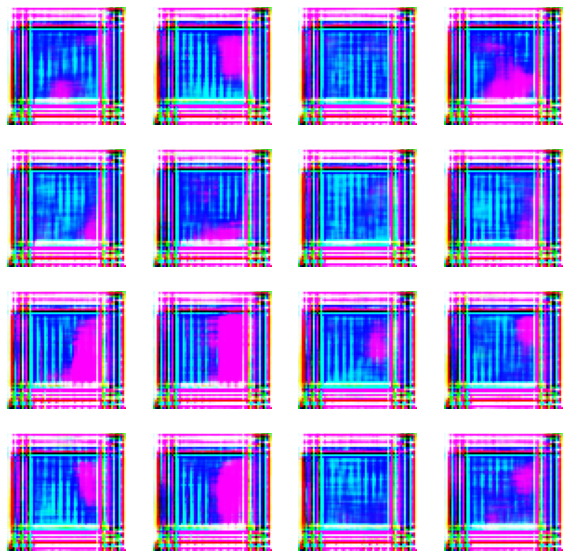

Time for epoch 250 is 22.909823656082153 sec
250 epoch, Discriminator accuracy Real/Fake: 100.0, 100.0; Generator accuracy: 100.0
250 epoch, Discriminator Loss Real/Fake: 3.381163906697554e-11,1.4847247707252676e-13 Generator loss: 1.0945636673867546e-08


In [104]:
train(gModel, dModel, ganModel, normTrainDS, noise_dim, BATCH_SIZE)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))


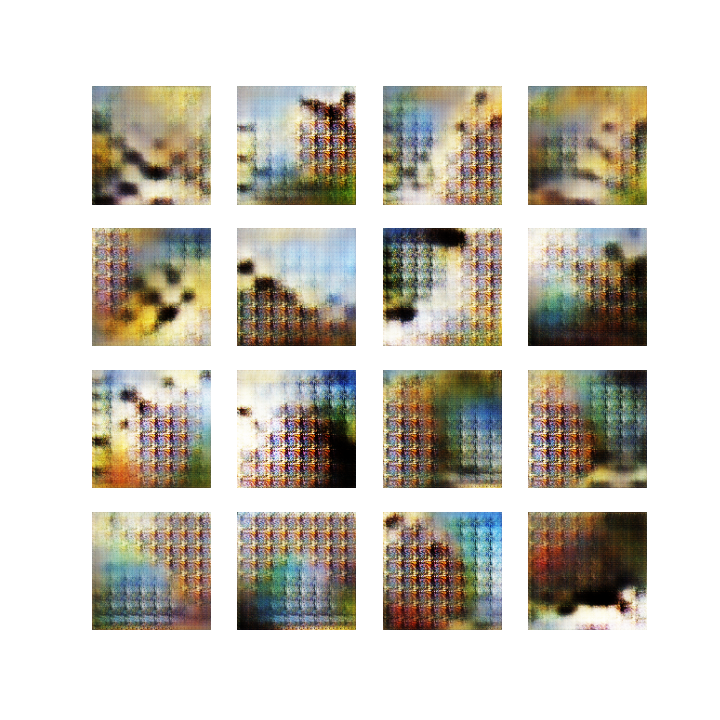

In [ ]:
display_image(EPOCHS)
# display_plot()

(16, 128, 128, 3)
tf.Tensor([0.5306679 0.6063865 0.7619484], shape=(3,), dtype=float32)


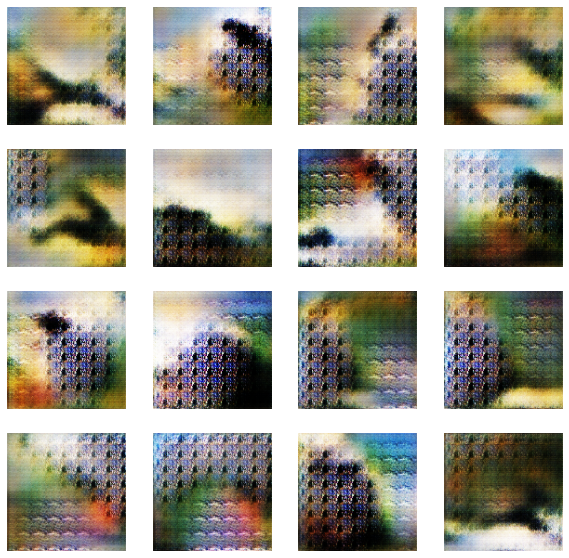

In [ ]:
generate_and_save_images(generator, 220, seed)

In [ ]:
anim_file = 'dcgan-landscape.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)
